In [83]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold

In [84]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [85]:
resumes_org = pd.read_csv('all_resumes.csv')
resumes_org.head()

,Resume,Category
0,Ui-Developer/ React JS Developer \n\nNAME: KRI...,React
1,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,React
2,HARIPRIYA BATTINA \n\nExperience as UI Develop...,React
3,"SARALA MADASU\n\nSARALA MADASU\n\n 204,Sri ge...",React
4,KAMALAKAR REDDY. A \n\nLinked In: https://www....,React


In [86]:
## Creating copy of original dataset
resumes = resumes_org.copy()

In [87]:
resumes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Resume    79 non-null     object
 1   Category  79 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [88]:
## Removing Special Characters

def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'  # Matches any character that is not a letter, digit, or whitespace
    clean_text = text.str.replace(pattern, '', regex=True)
    return clean_text

def remove_spaces(text):
    clean_text = text.str.replace(' ', '', regex=False)
    return clean_text

def remove_tabs(text):
    clean_text = text.str.replace('\t', '', regex=False)
    return clean_text

resumes_data = resumes
resumes_df = pd.DataFrame(resumes_data)

for column in resumes_df.columns:
    resumes_df[column] = remove_special_characters(resumes_df[column])
    
for column in resumes_df.columns:
    resumes_df[column] = remove_spaces(resumes_df[column])
    
for column in resumes_df.columns:
    resumes_df[column] = remove_tabs(resumes_df[column])

In [89]:
resumes = resumes.replace('is', '').replace('and', '').replace('on','').replace('in','').replace('resume','')


In [90]:
resumes.head()


,Resume,Category
0,Ui-Developer/ React JS Developer \n\nNAME: KRI...,React
1,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,React
2,HARIPRIYA BATTINA \n\nExperience as UI Develop...,React
3,"SARALA MADASU\n\nSARALA MADASU\n\n 204,Sri ge...",React
4,KAMALAKAR REDDY. A \n\nLinked In: https://www....,React


# Exploratory Data Analysis

In [91]:
## Grouping and aggregation
category_counts = resumes.groupby('Category').size()
category = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])
category

,Category,Count
0,Peoplesoft resumes,20
1,React,11
2,Reactjs,11
3,SQL Developer Lightning insight,14
4,internship,2
5,workday resumes,21


# Bar graph for Frequency

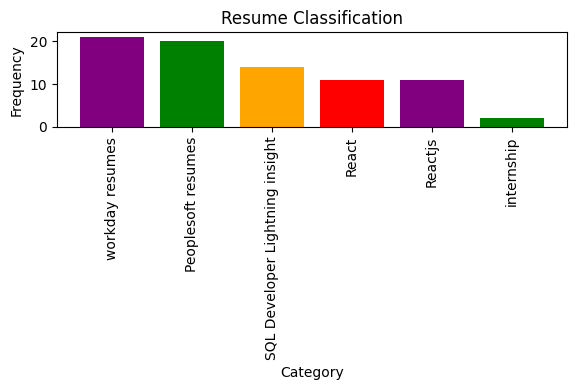

In [92]:
## Calculate the frequency of each category
category_counts = resumes['Category'].value_counts()

## Create the bar plot
colors = ['purple', 'green', 'orange', 'red']
plt.figure(figsize=(6, 4))
plt.bar(category_counts.index, category_counts.values, color=colors)

## Customize the plot
plt.xlabel('Category')
plt.xticks(rotation = 90)
plt.ylabel('Frequency')
plt.title('Resume Classification')

## Display the plot
plt.tight_layout()
plt.show()

# Pie chart for Percentage

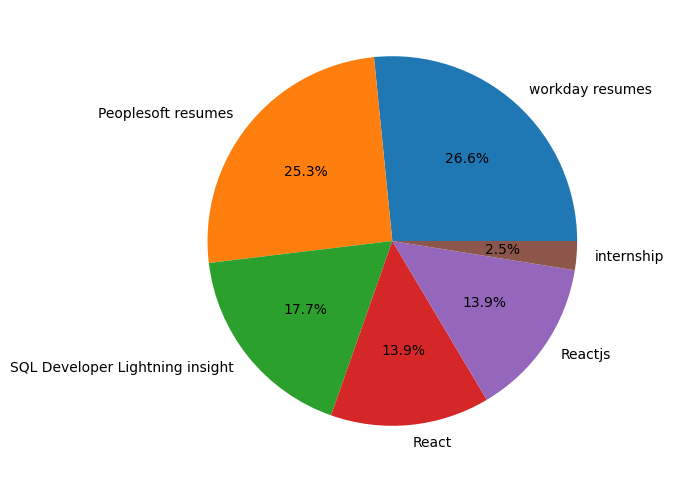

In [93]:
## Calculate percentage for each category
plt.figure(figsize=(8,6))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.show()

# Word cloud

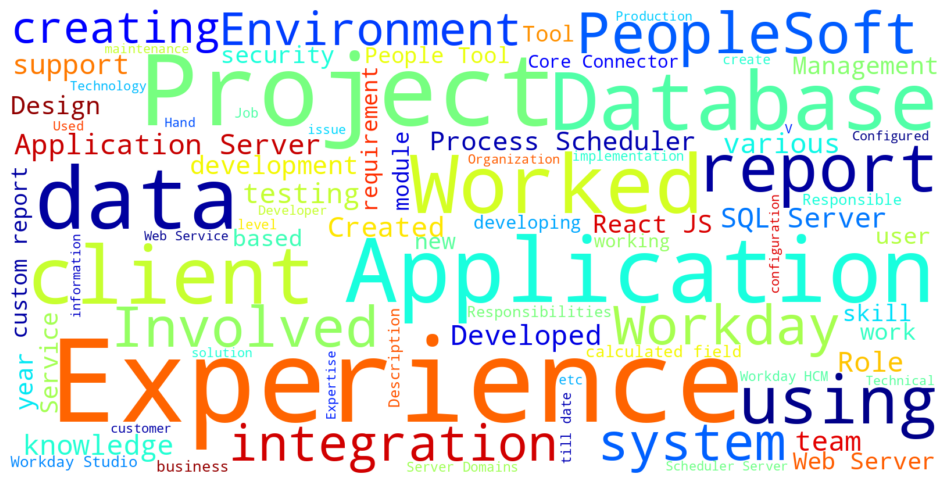

In [94]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(resumes['Resume'][:5000])

# Creating seperate columns for Experiance and skills

In [95]:
import spacy
from spacy import displacy

## Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

## Function to extract experience from text
def extract_experience(text):
    doc = nlp(text)
    experience = ''
    
    ## Extract experience using spaCy's entity recognition and dependency parsing
    for ent in doc.ents:
        if ent.label_ == "DATE" and 'year' in ent.text.lower():
            ## Extract the number of years from the entity text
            for token in doc:
                if token.idx >= ent.start_char and token.idx + len(token) <= ent.end_char:
                    if token.pos_ == 'NUM':
                        experience = token.text
                        break
    
    return experience

## Function to extract technical skills from text
def extract_technical_skills(text):
    doc = nlp(text.lower())
    skills = []

    specific_skills = [
        'react js', 'python' , 'javascript', 'html', 'css', 'webpack', 'npm',
         'hcm', 'report writer', 'eib', 'core connector',
        'sql', 'database', 'pl/sql', 'oracle', 'mysql', 't-sql'
        , 'hrms', 'peoplecode', 'application engine', 'sqr'
    ]

    for keyword in specific_skills:
        if keyword in text.lower():
            skills.append(keyword)

    return skills

## Load the CSV file
df = pd.read_csv('all_resumes.csv')

## Create new column for experience
df['Experience'] = df['Resume'].apply(extract_experience)
## Apply the extract_technical_skills function to the 'Extracted_text' column
df['Skills'] = df['Resume'].apply(extract_technical_skills)


## Save the modified DataFrame back to the Excel file
df.to_csv('Final.csv', index=False)

In [96]:
df = pd.read_csv('Final.csv')
df.head()

,Resume,Category,Experience,Skills
0,Ui-Developer/ React JS Developer \n\nNAME: KRI...,React,3.2,"['react js', 'javascript', 'html', 'css', 'npm']"
1,\n [pic]\n\nPROFILE\n\n Searching for the oppo...,React,2.0,"['javascript', 'html', 'css', 'sql', 'database..."
2,HARIPRIYA BATTINA \n\nExperience as UI Develop...,React,2018.0,"['react js', 'javascript', 'html', 'css', 'sql..."
3,"SARALA MADASU\n\nSARALA MADASU\n\n 204,Sri ge...",React,3.0,"['react js', 'javascript', 'html', 'css']"
4,KAMALAKAR REDDY. A \n\nLinked In: https://www....,React,3.0,"['react js', 'javascript', 'html', 'css']"


In [97]:
df = df.drop(['Resume'], axis=1)
df.head()

,Category,Experience,Skills
0,React,3.2,"['react js', 'javascript', 'html', 'css', 'npm']"
1,React,2.0,"['javascript', 'html', 'css', 'sql', 'database..."
2,React,2018.0,"['react js', 'javascript', 'html', 'css', 'sql..."
3,React,3.0,"['react js', 'javascript', 'html', 'css']"
4,React,3.0,"['react js', 'javascript', 'html', 'css']"


In [98]:
df.dtypes

Category       object
Experience    float64
Skills         object
dtype: object

In [99]:
df.isnull().sum()


Category      0
Experience    9
Skills        0
dtype: int64

In [100]:
## Read the DataFrame from the "Final.xlsx" file
df = pd.read_csv('Final.csv')

## Specify the column for which you want to fill outliers and null values
column_name = 'Experience'

## Calculate the mode of the column
mode_value = df[column_name].mode()[0]

## Fill outliers with the mode value
q1 = df[column_name].quantile(0.25)
q3 = df[column_name].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df[column_name] = df[column_name].apply(lambda x: mode_value if x < lower_bound or x > upper_bound else x)

## Fill null values with the mode value
df[column_name].fillna(mode_value, inplace=True)

## Save the modified DataFrame to a new Excel file
df.to_csv('Final data.csv', index=False)

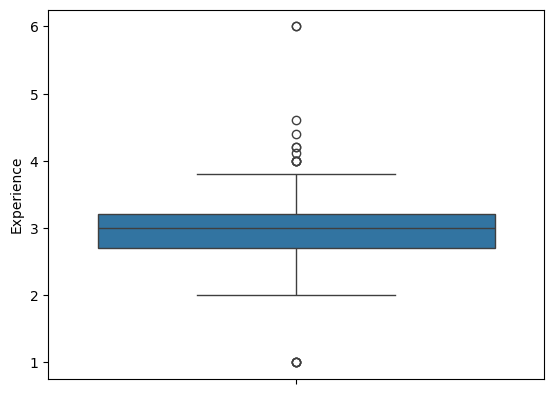

In [101]:
sns.boxplot(data=df, y= "Experience")
plt.show()

# Frequency for Skills

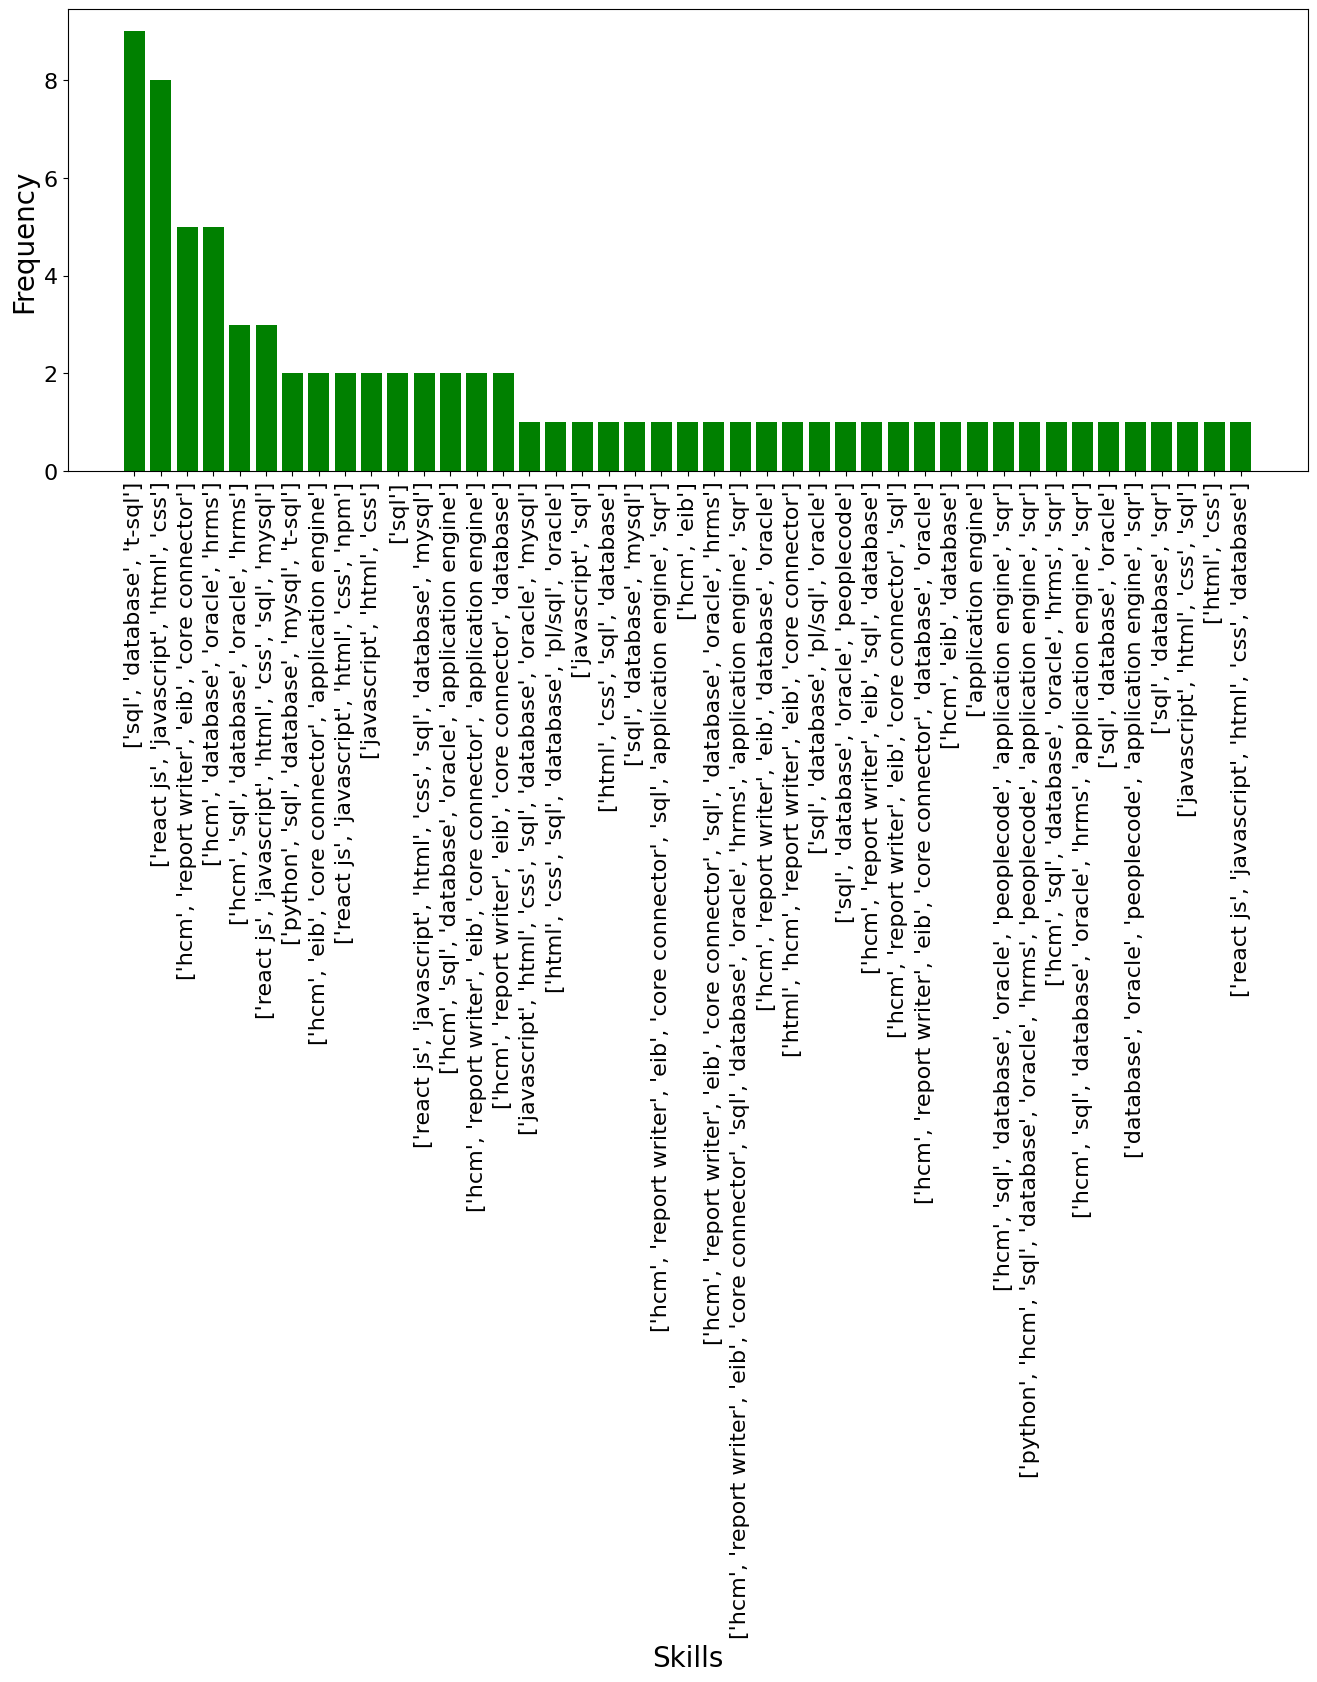

In [102]:
## Calculate the frequency of each category
category_counts = df['Skills'].value_counts()

## Create the bar plot
plt.figure(figsize=(16, 6))
plt.bar(category_counts.index, category_counts.values,color='green')

## Customize the plot
plt.xlabel('Skills',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=16)
plt.xticks(rotation=90)
plt.yticks(fontsize=16)
plt.show()

In [103]:
## Count individuals with JavaScript skills
count = sum('javascript' in skills for skills in df['Skills'])
print(f"Count of individuals with JavaScript skills: {count}")

Count of individuals with JavaScript skills: 21


# Proportion of Different Skills

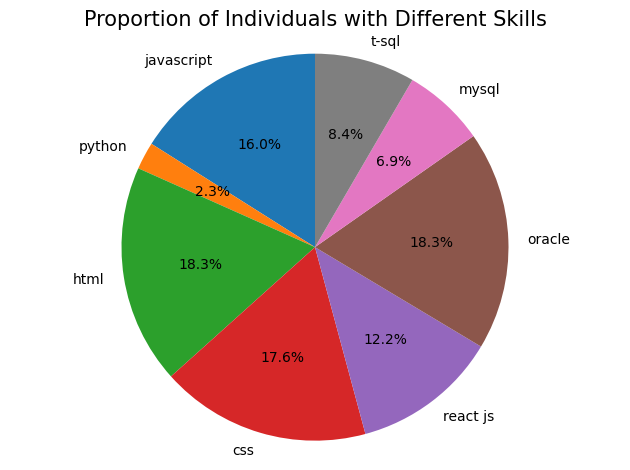

In [104]:
## Count individuals with each skill
skills = ['javascript', 'python', 'html', 'css', 'react js', 'oracle', 'mysql', 't-sql']
counts = [sum(skill in skills_list for skills_list in df['Skills']) for skill in skills]

## Create a pie chart
plt.pie(counts, labels=skills, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Individuals with Different Skills',fontsize=15)
plt.tight_layout()
plt.show()

# Proportion of JavaScript and SQL

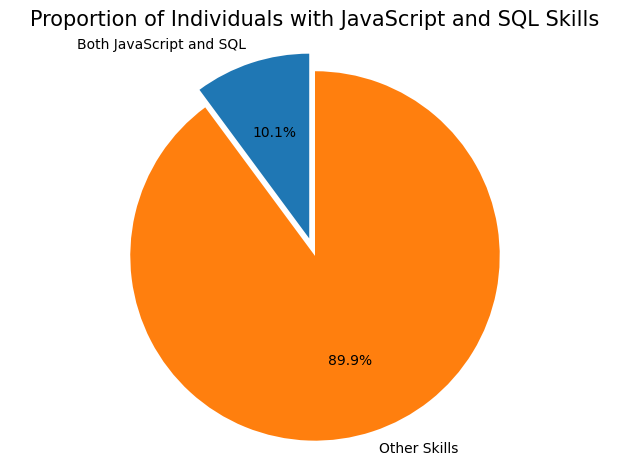

In [105]:
## Count individuals with both JavaScript and SQL skills
count = sum('javascript' in skills and 'sql' in skills for skills in df['Skills'])

## Calculate the proportion of individuals with both skills
total_individuals = len(df)
proportion = count / total_individuals

## Create a pie chart
labels = ['Both JavaScript and SQL', 'Other Skills']
sizes = [proportion, 1 - proportion]
explode = [0.1, 0]  ## Explode the "Both JavaScript and SQL" slice for emphasis

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  ## Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of Individuals with JavaScript and SQL Skills',fontsize=15)
plt.tight_layout()
plt.show()

# Scatter plot for Experience vs Number of Skills

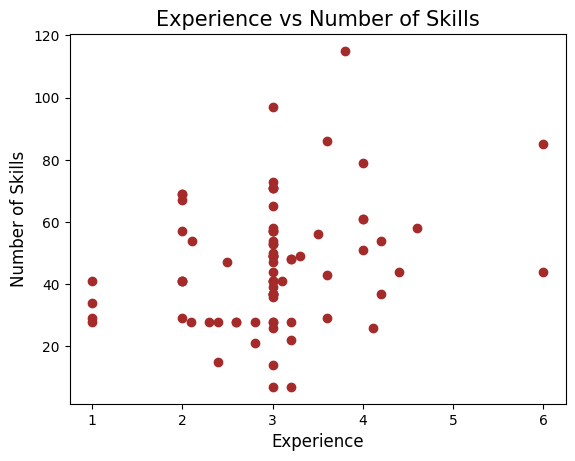

In [106]:
## Extract the experience and number of skills for each individual
experience = df['Experience']
num_skills = df['Skills'].apply(len)

## Create a scatter plot
plt.scatter(experience, num_skills,color='brown')
plt.xlabel('Experience',fontsize=12)
plt.ylabel('Number of Skills',fontsize=12)
plt.title('Experience vs Number of Skills',fontsize=15)
plt.show()

# Comparison of Experience Levels and Category

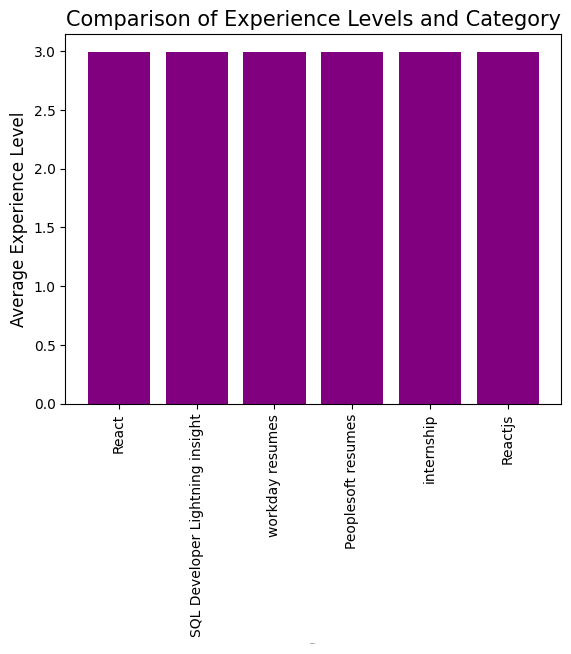

In [107]:
experience_levels = df['Experience']
## Count the occurrences of each experience level within the React Developer category
experience_counts = {}
for level in experience_levels:
    if level not in experience_counts:
        experience_counts[level] = 1
    else:
        experience_counts[level] += 1

## Calculate the average experience level for each category
average_experience = sum(float(level) for level in experience_levels) / len(experience_levels)

## Plotting
plt.bar(df['Category'], average_experience,color='purple')
plt.xlabel('Category',fontsize=1)
plt.xticks(rotation = 90)
plt.ylabel('Average Experience Level',fontsize=12)
plt.title('Comparison of Experience Levels and Category',fontsize=15)
plt.show()

# Skills in Each Category

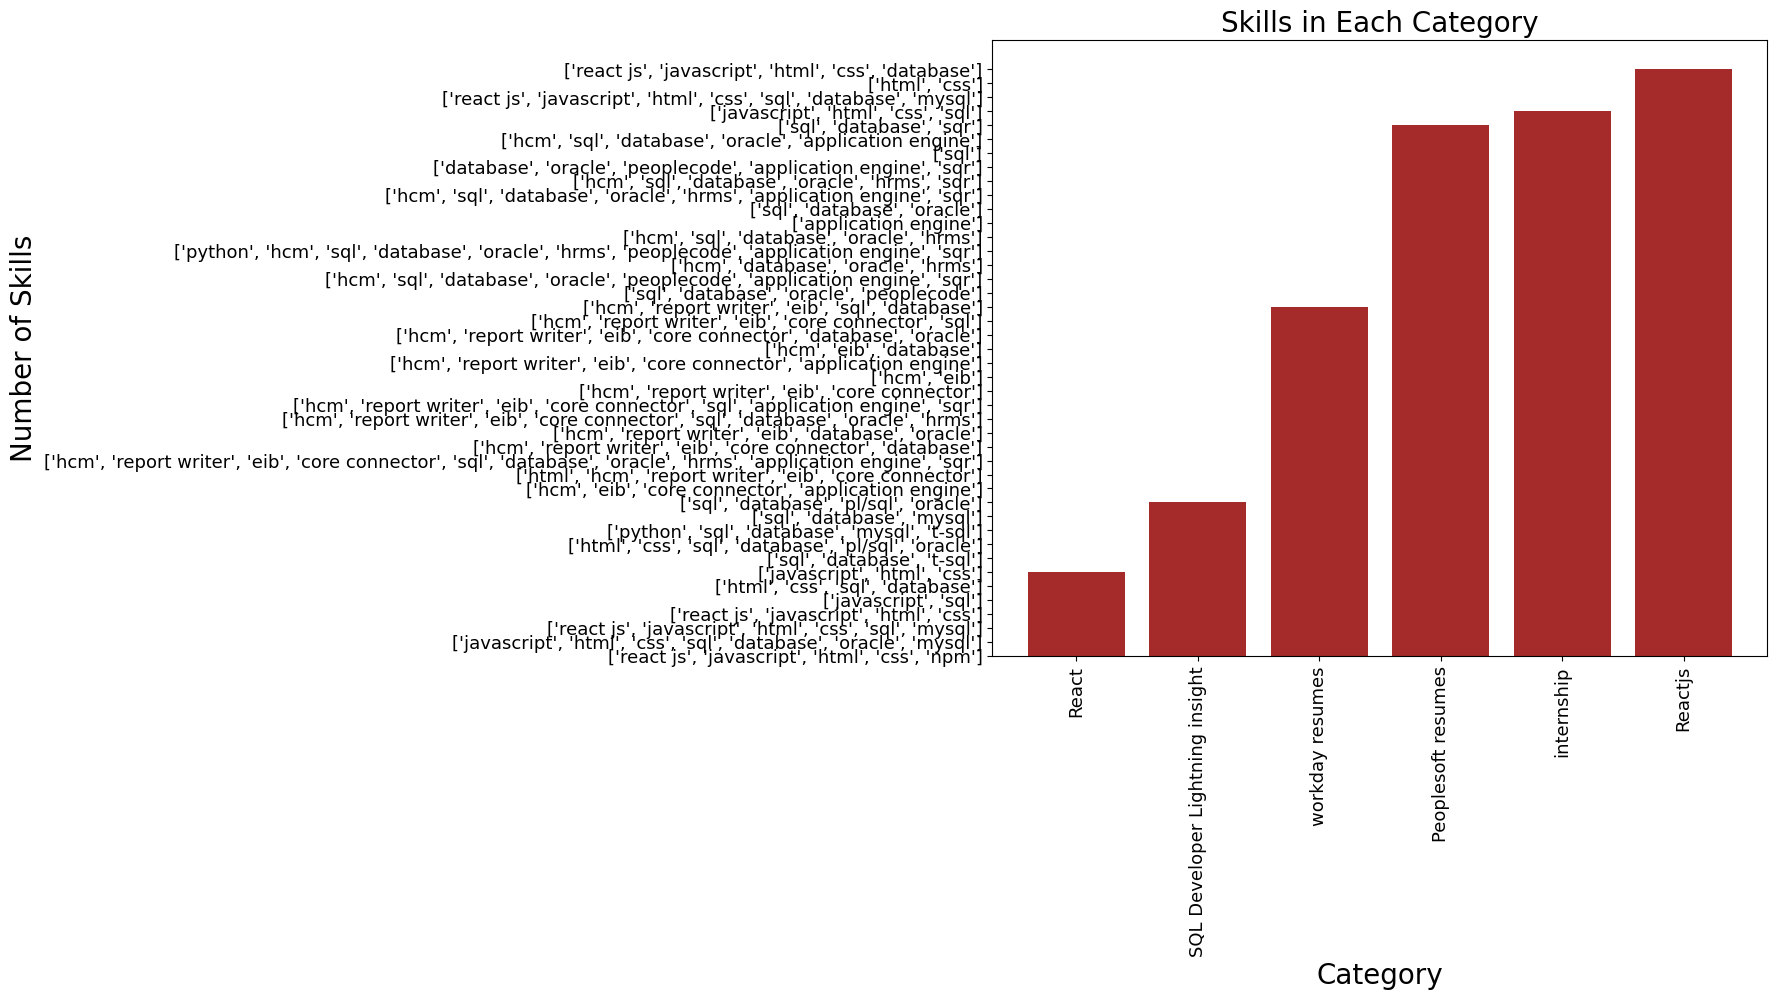

In [108]:
plt.figure(figsize=(10,8))
plt.bar(df['Category'], df['Skills'],color='brown')
plt.xlabel('Category',fontsize=(20))
plt.ylabel('Number of Skills',fontsize=(20))
plt.xticks(fontsize=13, rotation = 90)
plt.yticks(fontsize=13)
plt.title('Skills in Each Category',fontsize=(20))
plt.show()

# Model Building
1. Logistic Regression

In [109]:
## Separate the text and category
texts = resumes['Resume']
category = resumes['Category']

## Create a word count vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

## Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, category, test_size=0.2, random_state=42)

## Build the logistic regression model
model_1 = LogisticRegression()

## Train the model
model_1.fit(X_train, y_train)

## Evaluate the model
accuracy_1 = model_1.score(X_test, y_test)
print("Accuracy of Logistic Regression model:", accuracy_1)

Accuracy of Logistic Regression model: 0.75


In [110]:
# Make predictions
new_resume = ["Rahul  (Techno Functional Consultant)   Professional Summary Having Around 5+ years of experience in ERP Experience including 3 years in workday HCM and Expertise in Workday HCM , Benefits, Leave of Absence, Integration , Reporting , workday studio . Core Qualifications & Skills	 Involved in Full life cycle Workday implementation experience from requirement gathering to post deployment product support for HCM modules as well as various integrations in workday. Hands on configuring the Various Core HCM, Benefits ,Recruiting, Payroll ,Talent Modules . Expertise in Report writer, EIB, PICOF, DT, Workday Studio, CCW,CCB,BIRT, Calc Fields.  Expertise in Payroll integrations from workday to ADP , PS, by using PICOF and PECI . Developed and maintained custom-report types (Advanced, Matrix) using report writer tool. Hands on experience in creating BIRT layouts using Report Designer, for Using Report Designer. Involved in transformation of XML into XSLT for presenting data for different web Services. Expertise In Workday Security, leave absence, recruiting and Configuring the Befit 401 Plan etc. Good Knowledge  Creating leave families , Leave types , and absence condition rules in Module. Experience in inbound/outbound integration using EIB, CCW/CCB, Report Writing, creating Workday Cal fields, Custom report, (Matrix, Composite, trending, Advanced) BIRT tool . Configured the custom Dashboard and Created Reports and added to the various dash boards. Configured BP for leave of absence , Recuring , core HCM, written condition rules for steps etc. Expertise in building EIBs (Enterprise Interface Builder) integration within WD for sending Data Prioritizing, reproducing, and verifying bug fixes in different Workday integrations, reports BP’s. Ability to work creatively , analytically in a problem-solving workday Production environment, Interaction with all work streams including functional, conversion and project management. Expertise in developing Payroll interfaces using PICOF/ PECI with the help of Workday Studio and Document Transformation to  meet client’s complex payroll requirements using DT, Studio. Experience in understanding and gathering the business requirements, translating Functional specifications and develop code along with detailed design, Performed UTP test cases in wd. Excellent client interaction skills and experience in working independently as well as in a team. Developed Several Complex Integrations using Workday Studio and EIB CCW, PICOF, DT. Have good knowledge ETV/XTT functions in Document transformation for validating the data. Having knowledge in XML, WD-SOAP Web Service, and WD- REST Web Service and Experienced in  using such as Soap UI , Postman , XML Exchanger tools for testing API call . Experience on getting requirement from the client and handing sharing the work across team. Hands on experience in creating New security groups,  or updating security groups with various domains , security polices, activating security policies and identifying the security Objects . Professional  Working As software Engineer in  Infosys  From Jun 2016 – Till date.   Technical- Skills.   Education Details: Completed B-Tech from JNTU Anantapur 2016  with 70 %. Project Profile:- Project-2	   :   Implementation & Support  workday HCM Client	                 :  CDK Global . Role		   :  Workday Techno Functional Consultant.  Description: CDK Global is the largest global provider of integrated information technology and digital marketing solutions to automotive dealerships and manufacturers in more than 100 countries worldwide for the world’s biggest car brands Although we operate on a global scale we are small by comparison and that is a good thing It means that we are still a business where every person matters and where anyone can make an impact on our growth and success We have opportunities in a wide range of business areas so wherever in the world you join us you will get the support training and tools you need to make significant  Role and Responsibilities: Understanding the Business Requirements by studying the Functional Documents. Modified the XSLT code as per CR-request and adding the new XSLT for Different info types.  Create the new WD studio programs to sending AI-Statement to worker documents using BIRT. Creating the custom reports as per the client requirement and preparing the UTP documents. Created Workday Studio programs to load compensation data from ADP to workday. Created EIB Inbound Integrations for loading the employees personal Information like, Emergency contacts, , One-time payments, Bank account information, cost center information. Created EIB Integrations, written XSLT code and sending data from WD to downstream systems. Hands-on experience in creating the calculated fields using different functions complete logics.  Supporting the Different teams in UAT phase as with test factory teams during integration testing. Involved in calls with client and update the work status as well as clarifications if any. Handled Workday Service Upgrade Testing (WD29, WD30) for all the existing integrations Responsible for supporting the new change requests and enhancements in the project. Created calculated fields and worked on simple and advanced, matrix , Trending  reports. Worked on integrations systems (EIB’s, Core Connectors, PICOF.DT, Workday Studio). Day to day support of workday integrations, security, Business Process, and reporting issues. Coordinated with Onshore on requirements gathering, implementation, testing and enhancement of Integration, reports , business Process, EIB,BIRT and  workday studio integrations . Configured various business processes and created notifications to integrations, Reports etc. Design of web services to send/receive between Workday and Third-party system using API call . Developed analytics dashboards , data sources to provide actionable reporting  analytics. Deployed workday objects using Solutions from implementation to UAT, production tenants by following the change management process, solving the migration issues by using OX. Configured Leave family, leave type, Absence rules for countries as per business requirements Involved in Workday version upgrade testing and Scheduling and Monitoring Integrations. Expertise in developing Payroll interfaces using PICOF, PECI with the help of Workday Studio and DT to meet client’s complex payroll requirements sending to Diff payroll Vendors. Experienced in analyzing and preparing Project Deliverables Technical Design Document (TDD). Hands-on experience In Migrating the XSLT Code, Reports from Lower tenet to Sandbox and Production using Object Transporter.  Created the new outbound integrations to sending the time off corrections Information from workday to ADP payroll system. Project-2	   :   Implementation & Support  workday HCM Client	                 :  CDK Global . Role		   :  Workday  PS  Consultant.  Description: CDK Global is the largest global provider of integrated information technology and digital marketing solutions to automotive dealerships and manufacturers in more than 100 countries worldwide for the world’s biggest car brands Although we operate on a global scale we are small by comparison and that is a good thing It means that we are still a business where every person matters and where anyone can make an impact on our growth and success We have opportunities in a wide range of business areas so wherever in the world you join us you will get the support training and tools you need to make significant        Role and Responsibilities: Responsible for various customizations of fields, records, pages, components and menus as per the client requirements by using Application Designer Customized JOB DATA component to accommodate few more fields which are using as inputs for other systems and worked on APP engine, SQER, PS query, component Interface . Created CI with AE to import the JOB Requisitions data into PeopleSoft system from file and performed some validations before inserting to PS system. Was involved in functionality of sending Emails notifications through users with help of Send Mail Function. Used Process Scheduler to run scheduled process at a specific time and/or run recursively at a specific interval and used process Monitor to view status of the process. Creating new application engine program for sending employees data to third party system. Generating the Relocation Letters As per HR request and sending to the Daily Process Report to the client. Developed People Code to implement specific business rules and validations to enable the system to perform the business process."]
new_resume_vector = vectorizer.transform(new_resume)
prediction = model_1.predict(new_resume_vector)
print("Predicted category:", prediction[0])

Predicted category: workday resumes


# 2. Gaussian Naive bayes

In [111]:
## Separate the text and category
texts = resumes['Resume']
category = resumes['Category']

## Create a word count vectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(texts).toarray()

## Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, category, test_size = 0.2, random_state = 0)

## Build the naive bayes model
model_2 = GaussianNB()

## Train the model
model_2.fit(X_train, y_train)

## Predict 
y_pred = model_2.predict(X_test)

## Evaluate the model
cm = confusion_matrix(y_test, y_pred)
accuracy_2 = accuracy_score(y_test, y_pred)
print("Accuracy of Gaussian naive bayes model:", accuracy_2)

Accuracy of Gaussian naive bayes model: 0.75


# 3. KNeighbor Classification

In [112]:
## Label Encoding
var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    resumes[i] = le.fit_transform(resumes[i])
    
## Create a word count vectorizer
requiredText = resumes['Resume'].values
requiredTarget = resumes['Category'].values
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

## Split the data into training sets and test set
X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=0, test_size=0.2)

## Build the KNighbor Classification model
model_3 = OneVsRestClassifier(KNeighborsClassifier())

## Train the model
model_3.fit(X_train, y_train)

## Predict
prediction = model_3.predict(X_test)

## Evaluate the model
accuracy_3 = model_3.score(X_test, y_test)
print('Accuracy of KNeighbors Classifier model: {:.2f}'.format(accuracy_3))

Accuracy of KNeighbors Classifier model: 0.75


# 4 . XG Boost

In [113]:
## Seprate the text and category
texts = resumes['Resume']
category = resumes['Category']

## Create a word count vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

## Split the data into training and test set
X_train,X_test,y_train,y_test = train_test_split(X,category,test_size=0.2,random_state=42)

## Build the xgboost model
model_4 = XGBClassifier()

# Train the model
model_4.fit(X_train, y_train)

# Evaluate the model
accuracy_4 = model_4.score(X_test, y_test)
print("Accuracy of XGBOOST model:", accuracy_4)

Accuracy of XGBOOST model: 0.8125


# 5 .Support Vector Machine

In [114]:
## Separate the text and labels
texts = resumes['Resume']
category = resumes['Category']

## Create a word count vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

## Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, category, test_size=0.2, random_state=42)

## Build the SVM model
model_5 = SVC(kernel='linear')

## Train the model
model_5.fit(X_train, y_train)

## Evaluate the model
y_pred = model_5.predict(X_test)
accuracy_5 = accuracy_score(y_test, y_pred)
print("Accuracy of SVM model:", accuracy_5)

Accuracy of SVM model: 0.75


# 6.Decision Tree

In [115]:
## Separate the text and labels
texts = resumes['Resume']
category = resumes['Category']

## Create a word count vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

## Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, category, test_size=0.2, random_state=42)

## Build the Random Forest model
model_6 = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)

## Train the model
model_6.fit(X_train, y_train)

## Evaluate the model
y_pred = model_6.predict(X_test)
accuracy_6 = accuracy_score(y_test, y_pred)
print("Accuracy of Deicision Tree model:", accuracy_6)

Accuracy of Deicision Tree model: 0.75


# 7. Random Forest model

In [116]:
## Separate the text and labels
texts = resumes['Resume']
category = resumes['Category']

## Create a word count vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

## Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, category, test_size=0.2, random_state=42)

## Build the Random Forest model
model_7 = RandomForestClassifier()

## Train the model
model_7.fit(X_train, y_train)

## Evaluate the model
y_pred = model_7.predict(X_test)
accuracy_7 = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest model:", accuracy_7)

Accuracy of Random Forest model: 0.75


# 8. Convolutional Neural Networks (CNN) model

In [117]:
# Import necessary modules and functions
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder

# Assuming resumes is a DataFrame with columns 'Resume' and 'Category'
texts = resumes['Resume']
category = resumes['Category']

# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(category)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to have equal length
max_sequence_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_sequence_length)  # Fix the error here

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Build the CNN model
model_8 = Sequential()
model_8.add(Input(shape=(max_sequence_length,)))
model_8.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100))
model_8.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_8.add(MaxPooling1D(pool_size=2))
model_8.add(Flatten())
model_8.add(Dense(units=64, activation='relu'))
model_8.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

model_8.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_8.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy_8 = model_8.evaluate(X_test, y_test)
print("Accuracy of CNN model:", accuracy_8)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.2211 - loss: 1.9500
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3267 - loss: 1.5414
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5785 - loss: 1.2479
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4524 - loss: 1.0776
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5585 - loss: 1.0705
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7684 - loss: 0.6583
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8737 - loss: 0.5952
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9683 - loss: 0.3063
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9683 - loss: 0.2961
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9790 - loss: 0.2452
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5000 - loss: 1.7292
Accuracy of CNN model: 0.5


# Accuracy Comparison

In [118]:
df = pd.DataFrame({'Model':['Logistic Regression','Gaussian Naiv bayes','KNeighbor classification','XGBOOST','Support Vector Machines','Decision Tree','Random Forest','Neural Network'],
                 'Accuracy':[accuracy_1,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7,accuracy_8]})
print(df)

                      Model  Accuracy
0       Logistic Regression    0.7500
1       Gaussian Naiv bayes    0.7500
2  KNeighbor classification    0.7500
3                   XGBOOST    0.8125
4   Support Vector Machines    0.7500
5             Decision Tree    0.7500
6             Random Forest    0.7500
7            Neural Network    0.5000


# Cross Validation
Logistic Regression

In [119]:

accuracies = cross_val_score(estimator = model_1, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 39.52 %
Standard Deviation: 25.82 %


# Support Vector Machine

In [120]:
accuracies = cross_val_score(estimator = model_5, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 41.43 %
Standard Deviation: 19.23 %


# Decision Tree

In [121]:
accuracies = cross_val_score(estimator = model_6, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 30.24 %
Standard Deviation: 15.25 %


# Random Forest

In [122]:
accuracies = cross_val_score(estimator = model_7, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 35.48 %
Standard Deviation: 18.08 %
